In [1]:
#########
# tested on 
# python 3.7
# tensorflow 1.13.1
#
# run following commands in the terminal
#
# conda install tensorflow=1.13.1
# conda install go
# go get -u github.com/fogleman/primitive
#
##########

import tensorflow as tf

import numpy as np
import inceptionv3
from utils import *

# if the tensorflow is GPU version, may following code
#
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

# import the new primitive_defend function
from primitive_tensor import *

tf.__version__

'1.13.1'

In [2]:
sess = tf.Session()

# Image and target class

Choose what you want here.
This workthrough use the 1000 as the BPDA defense set up

In [4]:
# other examples:
# orig = load_image('dogsled.jpg')
#
# load_image gives range 0~1.0 
orig = load_image('test_val_1k/val/ILSVRC2012_val_00013196.JPEG')
TARGET = 924 # guacamole

# Inception v3 Classifier

In [3]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_expanded = tf.expand_dims(x, axis=0)
logits, preds = inceptionv3.model(sess, x_expanded)

INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/cwang/projects/sparse_representation/data/inception_v3.ckpt


In [5]:
probs = tf.nn.softmax(logits)
classify = make_classify(sess, x, probs)

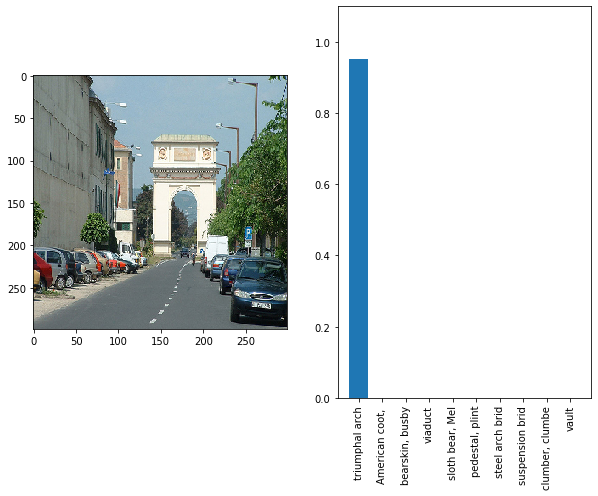

In [6]:
classify(orig, target_class=TARGET)

# Triangulate Original Image

In [7]:
y = primitive_defend(orig, n_triangle=1000)

step 0, processing ./ram/input_00000.png


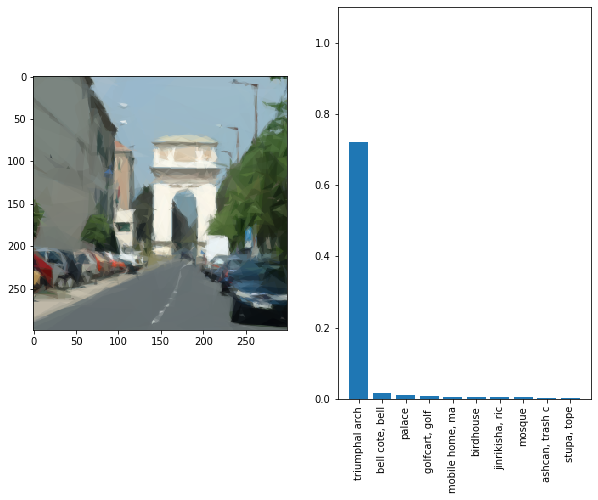

In [8]:
classify(y[0,:,:,:], target_class=TARGET)

# Successful White-box Attacks Against Original Classifier

In [9]:
l2_x = tf.placeholder(tf.float32, (299, 299, 3))
l2_orig = tf.placeholder(tf.float32, (299, 299, 3))
normalized_l2_loss = tf.nn.l2_loss(l2_orig - l2_x) / tf.nn.l2_loss(l2_orig)

xent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot(TARGET, 1000))
lam = tf.placeholder(tf.float32, ())
loss = xent + lam * normalized_l2_loss
grad, = tf.gradients(loss, x)

In [10]:
LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(20): # for i in range(10):
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], 
                        {x: adv, lam: LAM, l2_x: adv, l2_orig: orig})
    print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, l2=0.000000, pred=873
step 1, l2=0.000011, pred=873
step 2, l2=0.000017, pred=873
step 3, l2=0.000024, pred=873
step 4, l2=0.000034, pred=873
step 5, l2=0.000045, pred=873
step 6, l2=0.000055, pred=727
step 7, l2=0.000060, pred=873
step 8, l2=0.000068, pred=924
step 9, l2=0.000074, pred=873
step 10, l2=0.000090, pred=924
step 11, l2=0.000097, pred=924
step 12, l2=0.000109, pred=727
step 13, l2=0.000121, pred=924
step 14, l2=0.000140, pred=924
step 15, l2=0.000151, pred=924
step 16, l2=0.000155, pred=924
step 17, l2=0.000156, pred=924
step 18, l2=0.000157, pred=924
step 19, l2=0.000157, pred=924


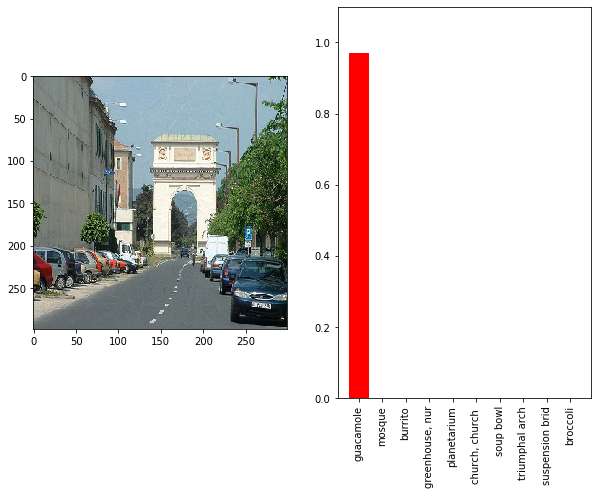

In [11]:
classify(adv, target_class=TARGET)

# Failed Grey-box Attacks Against Protected Classifier

In [12]:
purified = primitive_defend(adv, n_triangle=1000)

step 0, processing ./ram/input_00000.png


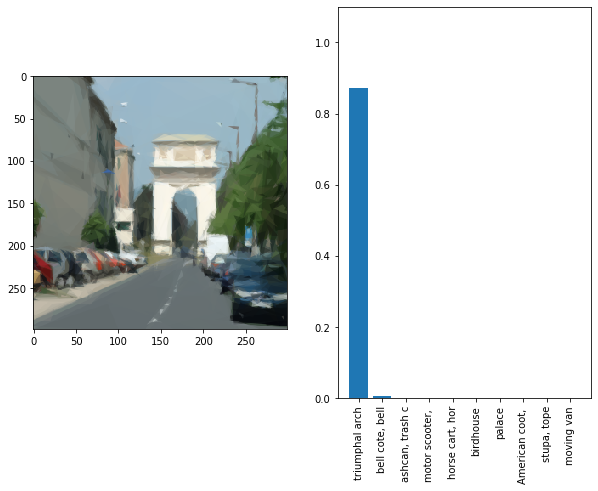

In [13]:
classify(purified[0,:,:,:])

# White-box Attacks Against Protected Classifier

Using BPDA.

In [14]:
# BPDA
# This cell takes very long time
# Please wait for the results

LAM = 1.0
LR = 0.1

adv = np.copy(orig)
for i in range(50):
    adv_def = primitive_defend(adv, n_triangle=1000)
    print(adv_def.shape) # (1,299,299,3)
    g, l2, p = sess.run([grad, normalized_l2_loss, preds], 
                        {x: adv_def[0,:,:,:], lam: LAM, l2_x: adv, l2_orig: orig})
    if i % 10 == 0:
        print('step %d, l2=%f, pred=%d' % (i, l2, p))
    # step
    adv -= LR * g
    # project
    adv = np.clip(adv, 0, 1)

step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, l2=0.000000, pred=873
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 10, l2=0.001491, pred=873
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, processing ./ram/input_00000.png
(1, 299, 299, 3)
step 0, pro

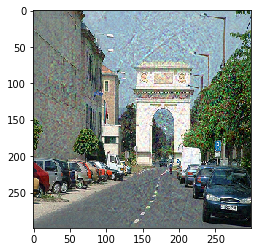

In [15]:
plt.imshow(adv)

In [18]:
# n_triangle = 1000 gives best defense result
# 
purified_1000 = primitive_defend(adv, n_triangle=1000)[0,:,:,:]

step 0, processing ./ram/input_00000.png


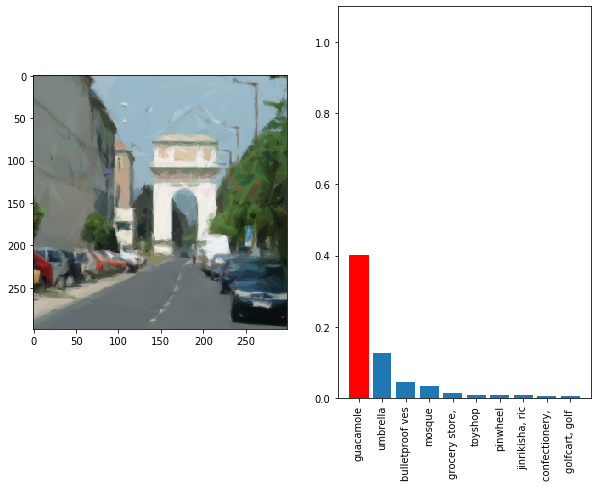

In [19]:
classify(purified_1000, target_class=TARGET)